In [19]:
import os
import sys
import time
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


for module in np, pd, sklearn, mpl, tf, keras:
    print(module.__name__, module.__version__)
print(sys.version_info)

numpy 1.17.4
pandas 0.25.3
sklearn 0.22
matplotlib 3.1.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf
sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)


## 1.获取并处理数据

### 1.1 读取数据

In [20]:
input_filepath = "./shakespeare.txt"

with open(input_filepath, "r") as f:
    text = f.read()

print(len(text))
pprint(text[:100])

1115394
('First Citizen:\n'
 'Before we proceed any further, hear me speak.\n'
 '\n'
 'All:\n'
 'Speak, speak.\n'
 '\n'
 'First Citizen:\n'
 'You')


### 1.2 生成词表

In [3]:
vocab =sorted(set(text))  # 给字符排序
print(vocab, len(vocab))

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 65


### 1.3 构造词表映射

In [4]:
# build mapping char -> id
char2idx = {char:idx for idx, char in enumerate(vocab)}
print(char2idx)

idx2char = np.array(vocab)
print(idx2char)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


### 1.4 将文本数据集转换为ID数据集

In [5]:
text_as_int = np.array([char2idx[c] for c in text])
print(text_as_int[:10])
print(text[:10])

[18 47 56 57 58  1 15 47 58 47]
First Citi


### 1.5 将ID数据集转为dataset，并设定句子长度

In [6]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
seq_length = 100   # 设置句子长度（并不是以自然的句子方式结尾，而是限定长度）
seq_dataset = char_dataset.batch(
    seq_length+1, # 训练集与目标集要错一位进行预测
    drop_remainder=True)  # 最后一批如果长度不满足seq_length + 1则舍去

for ch_id in char_dataset.take(1):
    print(ch_id, idx2char[ch_id.numpy()])
    
for seq_id in seq_dataset.take(1):
    print(seq_id)
    print(repr("".join(idx2char[seq_id.numpy()])))

tf.Tensor(18, shape=(), dtype=int32) F
tf.Tensor(
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1], shape=(101,), dtype=int32)
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### 1.6 划分数据集为train_data和_train_labels

In [7]:
def split_input_target(id_text):
    """ abcde -> abcd(input), bcde(output) """
    return id_text[0:-1], id_text[1:]

seq_dataset = seq_dataset.map(split_input_target)

for item in seq_dataset.take(1): # 解包
    print("Input: ")
    print(item[0].numpy())
    print("Output: ")
    print(item[1].numpy())

Input: 
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59]
Output: 
[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43  1
 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43 39
 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49  6
  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0
 37 53 59  1]


In [8]:
batch_size = 64
buffer_size = 10000

seq_dataset = seq_dataset.shuffle(buffer_size).batch(
    batch_size, drop_remainder=True)

for item in seq_dataset.take(1):
    print(item)

(<tf.Tensor: id=61, shape=(64, 100), dtype=int32, numpy=
array([[ 6,  1, 50, ..., 43,  8,  1],
       [ 1, 58, 46, ..., 51, 39, 52],
       [53, 52, 43, ..., 15, 17, 31],
       ...,
       [26, 33, 31, ..., 57, 57,  8],
       [ 1, 57, 58, ..., 42, 53, 52],
       [46,  1, 53, ..., 53, 58, 46]])>, <tf.Tensor: id=62, shape=(64, 100), dtype=int32, numpy=
array([[ 1, 50, 43, ...,  8,  1, 35],
       [58, 46, 39, ..., 39, 52, 42],
       [52, 43,  0, ..., 17, 31, 32],
       ...,
       [33, 31, 10, ..., 57,  8,  0],
       [57, 58, 39, ..., 53, 52,  1],
       [ 1, 53, 52, ..., 58, 46, 47]])>)


## 2. RNN建模

### 2.1 建模

In [9]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 200

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = keras.models.Sequential([
        keras.layers.Embedding(vocab_size,
                               embedding_dim,),
#                                batch_input_shape=[batch_size, None]),
        keras.layers.SimpleRNN(units=rnn_units,
                               return_sequences=True),
        keras.layers.Dense(vocab_size)
    ])
    return model

model = build_model(vocab_size=vocab_size,
                    embedding_dim=embedding_dim,
                    rnn_units=rnn_units,
                    batch_size=batch_size)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         16640     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 200)         91400     
_________________________________________________________________
dense (Dense)                (None, None, 65)          13065     
Total params: 121,105
Trainable params: 121,105
Non-trainable params: 0
_________________________________________________________________


### 2.2 使用初始模型进行预测 

In [10]:
for input_example_batch, target_example_batch in seq_dataset.take(1):
    # 利用初始化的模型进行预测
    example_batch_predictions = model(input_example_batch)  
    print(example_batch_predictions.shape)

(64, 100, 65)


In [11]:
# random sampling
# greedy, random 贪心采样与随机采样
# (100, 65) -> (100, 1)
# tf.random.categorical输入维度必须为二维
sample_indices = tf.random.categorical(logits=example_batch_predictions[0],
                                       num_samples=1)
print(sample_indices)   
sample_indices = tf.squeeze(sample_indices, axis=-1)
print(sample_indices)

tf.Tensor(
[[54]
 [28]
 [46]
 [49]
 [ 8]
 [32]
 [20]
 [52]
 [60]
 [49]
 [64]
 [22]
 [13]
 [55]
 [13]
 [47]
 [55]
 [57]
 [24]
 [42]
 [32]
 [14]
 [54]
 [57]
 [31]
 [19]
 [43]
 [31]
 [63]
 [24]
 [13]
 [ 5]
 [ 2]
 [38]
 [49]
 [42]
 [62]
 [14]
 [49]
 [52]
 [54]
 [13]
 [ 7]
 [15]
 [64]
 [38]
 [40]
 [48]
 [29]
 [59]
 [43]
 [53]
 [27]
 [60]
 [49]
 [33]
 [48]
 [57]
 [14]
 [14]
 [52]
 [51]
 [13]
 [47]
 [54]
 [32]
 [58]
 [30]
 [16]
 [64]
 [29]
 [38]
 [22]
 [28]
 [41]
 [ 0]
 [10]
 [63]
 [60]
 [27]
 [39]
 [19]
 [ 8]
 [ 9]
 [22]
 [54]
 [18]
 [ 3]
 [58]
 [ 4]
 [32]
 [32]
 [55]
 [40]
 [26]
 [ 2]
 [57]
 [21]
 [26]
 [63]], shape=(100, 1), dtype=int64)
tf.Tensor(
[54 28 46 49  8 32 20 52 60 49 64 22 13 55 13 47 55 57 24 42 32 14 54 57
 31 19 43 31 63 24 13  5  2 38 49 42 62 14 49 52 54 13  7 15 64 38 40 48
 29 59 43 53 27 60 49 33 48 57 14 14 52 51 13 47 54 32 58 30 16 64 29 38
 22 28 41  0 10 63 60 27 39 19  8  9 22 54 18  3 58  4 32 32 55 40 26  2
 57 21 26 63], shape=(100,), dtype=int64)


In [12]:
print("Input: ", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Output: ", repr("".join(idx2char[target_example_batch[0]])))
print()
print("Prediction: ", repr("".join(idx2char[sample_indices])))

Input:  ' temper with the stars:\nYet in this one thing let me blame your grace,\nFor choosing me when Clarence'

Output:  'temper with the stars:\nYet in this one thing let me blame your grace,\nFor choosing me when Clarence '

Prediction:  "pPhk.THnvkzJAqAiqsLdTBpsSGeSyLA'!ZkdxBknpA-CzZbjQueoOvkUjsBBnmAipTtRDzQZJPc\n:yvOaG.3JpF$t&TTqbN!sINy"


In [13]:
def loss(labels, logits):
    return keras.losses.sparse_categorical_crossentropy(
        labels,
        logits,
        from_logits=True) # 最后一层神经网络中没有激活函数softmax，
                          # 所以不是归一化形式

model.compile(optimizer="adam", loss=loss)
example_loss = loss(target_example_batch, example_batch_predictions)
print(target_example_batch.shape)
print(example_batch_predictions.shape)
print(example_loss.shape)
print(example_loss.numpy().mean())

(64, 100)
(64, 100, 65)
(64, 100)
4.188471


In [14]:
output_dir = "./text_generation_checkpoints"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
# 使用多个checkpoint文件记录每个epoch中的参数值，以前只用checkpoint记录所有
# epoch中效果最好的模型，并且把参数记录在一个h5文件中，这里有所不同
checkpoint_prefix = os.path.join(output_dir, "ckpt_{epoch}")
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

epochs = 100
history = model.fit(seq_dataset, 
                    epochs=epochs,
                    callbacks=[checkpoint_callback])

Epoch 1/100
172/172 [==============================] - 20s 115ms/step - loss: 2.6116
Epoch 2/100
172/172 [==============================] - 21s 122ms/step - loss: 2.0878
Epoch 3/100
172/172 [==============================] - 20s 114ms/step - loss: 1.9268
Epoch 4/100
172/172 [==============================] - 18s 107ms/step - loss: 1.8274
Epoch 5/100
172/172 [==============================] - 18s 106ms/step - loss: 1.7593
Epoch 6/100
172/172 [==============================] - 19s 108ms/step - loss: 1.7106
Epoch 7/100
172/172 [==============================] - 18s 107ms/step - loss: 1.6718
Epoch 8/100
172/172 [==============================] - 19s 108ms/step - loss: 1.6418
Epoch 9/100
172/172 [==============================] - 18s 103ms/step - loss: 1.6168
Epoch 10/100
172/172 [==============================] - 17s 99ms/step - loss: 1.5963
Epoch 11/100
172/172 [==============================] - 17s 99ms/step - loss: 1.5787
Epoch 12/100
172/172 [==============================] - 16s 96ms/

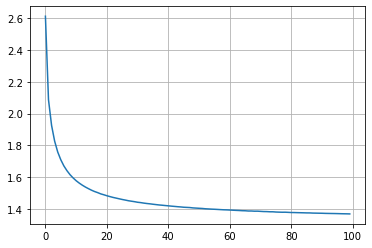

In [15]:
history.history.keys()
def plot_loss_curves(history):
    plt.plot(range(epochs), history.history["loss"])
    plt.grid(True)
    plt.show()

plot_loss_curves(history)

## 3. 使用checkpoint载入模型

In [16]:
print(tf.train.latest_checkpoint(output_dir))

./text_generation_checkpoints\ckpt_100


In [17]:
model2 = build_model(vocab_size,
                     embedding_dim,
                     rnn_units,
                     batch_size=1)
model2.load_weights(tf.train.latest_checkpoint(output_dir))
model2.build(tf.TensorShape([1, None])) # model2.build([1, None])
                                        # 输入是一个变长
# start ch sequence A,
# A -> model -> b
# A.append(b) -> B
# B(Ab) -> model -> c
# b.append(c) -> C
# C(Abc) -> model -> ...
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 200)         91400     
_________________________________________________________________
dense_1 (Dense)              (None, None, 65)          13065     
Total params: 121,105
Trainable params: 121,105
Non-trainable params: 0
_________________________________________________________________


## 4.生成文本

In [18]:
def generate_text(model, start_string, num_generate=1000):
    input_eval = [char2idx[ch] for ch in start_string]
    input_eval = tf.expand_dims(input_eval, axis=0)
    
    text_generated = []
    model.reset_states()     # ???????????
    
    for _ in range(num_generate):
        # 1. model inderence -> predictions
        # 2. sample -> ch -> text_generated.
        # 3. update input_eval
        
        # predictions : [batch_size, input_eval_len, vocab_size]
        predictions = model(input_eval)
        # predictions : [input_eval_len, vocab_size]
        predictions = tf.squeeze(predictions, 0)
        # prediction_ids: [input_eval_len, 1]
        # a b c -> b c d
        prediction_id = tf.random.categorical(predictions,
                                              num_samples=1)[-1, 0].numpy()
        text_generated.append(idx2char[prediction_id])
        input_eval = tf.expand_dims([prediction_id], 0)
    return start_string + "".join(text_generated)

new_text = generate_text(model2, "All: ")
print(new_text)

All: your' h d t JORDIZo r'linging h, n Myongoce a wes ur me; hean I thow han hang d thoulor gg s m? mond phe. am co has d le bus, y. binou t, hante cerame scke weandonty lons,
CES fldlokethandabser g gra we wes!
USThinwhan st t w ase we heambomomit tas uthy,

Ift tr t wer thend my in.
VO:
ANUplyo I he ge thato ththickepondotholulon G uspt.
AUS:
Butlly cked stly thatt,
Whow f w Amivon't in f prinopithouthend; pece mocomin athathit tony bulerodeard atud cous merath h thirse,
STR rdeved
athan,
An;
SThe urescy ge I th, thouly't.
That wicke fit fe! benote w m

CUSevell d?
Me!
BYO, mut t, at t no,
Fofus r, aker, are yo ind thit.
I atoche
D:
RO:
bont IOLIZAREThatinowivican a g witr?
ARilicknoran
IULA:
QUSo fut t, ath nichan hirs Pered lack theave thalulithacus t ir be spe s, or e e;
TRULAs areveyowanacheday tey;
BUCLLI: d hasttlust t borane; wnd blo s marithas,
A:
Lowan m f hasenth
TARUCLO, an ldivy weve! pr te, r t myo INeysomit PENTouphean r! t s

I ghy onge ant s, Whe thafuler?
CA:
K:

CL